In [1]:
%pip install torchvision

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 7, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 38.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 18.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 9.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 35.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 57.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 49.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 37.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━

In [2]:
import pandas as pd

# load our data 
train_df = spark.sql("SELECT * FROM SnapshotSerengeti_LH.sampled_train")

# convert train_df to pandas dataframe
train_df = train_df.toPandas()

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 9, Finished, Available, Finished)

In [3]:
# Create a new column in the dataframe 
train_df['image_url'] = train_df['filename'].apply(lambda filename: f"/lakehouse/default/Files/images/train/{filename}")

train_df.head()

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 10, Finished, Available, Finished)

filename            label  \
0  S1/D06/D06_R1/S1_D06_R1_PICT1558.JPG  gazellethomsons   
1  S1/R12/R12_R1/S1_R12_R1_PICT0485.JPG  gazellethomsons   
2  S2/H04/H04_R3/S2_H04_R3_PICT0300.JPG  gazellethomsons   
3  S2/H07/H07_R2/S2_H07_R2_PICT1508.JPG  gazellethomsons   
4  S5/D10/D10_R1/S5_D10_R1_IMAG2878.JPG  gazellethomsons   

                                           image_url  
0  /lakehouse/default/Files/images/train/S1/D06/D...  
1  /lakehouse/default/Files/images/train/S1/R12/R...  
2  /lakehouse/default/Files/images/train/S2/H04/H...  
3  /lakehouse/default/Files/images/train/S2/H07/H...  
4  /lakehouse/default/Files/images/train/S5/D10/D...

In [4]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the label column in the train_df DataFrame
le.fit(train_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
train_df['labels'] = le.transform(train_df['label'])

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 11, Finished, Available, Finished)

In [6]:
# Repeat the process for the test dataset
test_df = spark.sql("SELECT * FROM SnapshotSerengeti_LH.sampled_test")

# convert test_df to pandas dataframe
test_df = test_df.toPandas()

# Create a new column in the dataframe using the apply method
test_df['image_url'] = test_df['filename'].apply(lambda filename: f"/lakehouse/default/Files/images/train/{filename}")

# Fit the LabelEncoder to the label column in the test_df DataFrame
le.fit(test_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
test_df['labels'] = le.transform(test_df['label'])

# combine both the train and test dataset
data = pd.concat([test_df, train_df])

# drop filename column 
data = data[['image_url', 'labels']]

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 13, Finished, Available, Finished)

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        while True:
            img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
            if not os.path.exists(img_name):
                idx = (idx + 1) % len(self.data)
                continue
            image = Image.open(img_name)
            if self.transform:
                image = self.transform(image)
            labels = self.data.iloc[idx, 1]
            return image, labels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = CustomDataset("/lakehouse/default/Files/images/train/", transform=transform)
test_set = CustomDataset("/lakehouse/default/Files/images/test/", transform=transform)

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 14, Finished, Available, Finished)

In [8]:
# Load the training and test data
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 15, Finished, Available, Finished)

In [9]:
# Using mlflow library to activate our ml experiment

import mlflow

mlflow.set_experiment("serengeti-experiment")

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 16, Finished, Available, Finished)

2025/04/01 08:21:01 INFO mlflow.tracking.fluent: Experiment with name 'serengeti-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1743495665446, experiment_id='4905cd77-d14d-4b25-8d6f-da36c307929d', last_update_time=None, lifecycle_stage='active', name='serengeti-experiment', tags={}>

In [12]:
import torchvision
import torch
import torch.nn as nn
from torchvision.models import DenseNet201_Weights

# load the pre-trained DenseNet 201 model
model = torchvision.models.densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 53)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 19, Finished, Available, Finished)

In [13]:
import torch.optim as optim

# define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 20, Finished, Available, Finished)

In [14]:
# train the model
num_epochs = 5
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_loader, ):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
    print('Finished Training')

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 21, Finished, Available, Finished)

Epoch 0/4
----------
Finished Training
Epoch 1/4
----------
Finished Training
Epoch 2/4
----------
Finished Training
Epoch 3/4
----------
Finished Training
Epoch 4/4
----------
Finished Training


In [15]:
# use an MLflow run and track the results within our machine learning experiment.

with mlflow.start_run() as run:
    print("log pytorch model:")
    mlflow.pytorch.log_model(
        model, "pytorch-model",
        registered_model_name="serengeti-pytorch"
    )
    
    model_uri = "runs:/{}/pytorch-model".format(run.info.run_id)
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 22, Finished, Available, Finished)

log pytorch model:
Model saved in run bdd51800-8ea4-4acc-9ae2-d3618de98094
Model URI: runs:/bdd51800-8ea4-4acc-9ae2-d3618de98094/pytorch-model


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'serengeti-pytorch'.


In [16]:
# load and evaluate the model
loaded_model = mlflow.pytorch.load_model(model_uri)
print(type(loaded_model))
correct_cnt, total_cnt, ave_loss = 0, 0, 0
for batch_idx, (x, target) in enumerate(test_loader):
    x, target = x, target
    out = loaded_model(x)
    loss = criterion(out, target)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    ave_loss = (ave_loss * batch_idx + loss.item()) / (batch_idx + 1)
    
    if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(test_loader):
        print(
            "==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}".format(
                epoch, batch_idx + 1, ave_loss, correct_cnt * 1.0 / total_cnt
            )
        )

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 23, Finished, Available, Finished)

2025/04/01 08:46:15 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


<class 'torchvision.models.densenet.DenseNet'>
==>>> epoch: 4, batch index: 7, test loss: 28.146671, acc: 0.242


StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 24, Finished, Available, Finished)

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 27, Finished, Available, Finished)

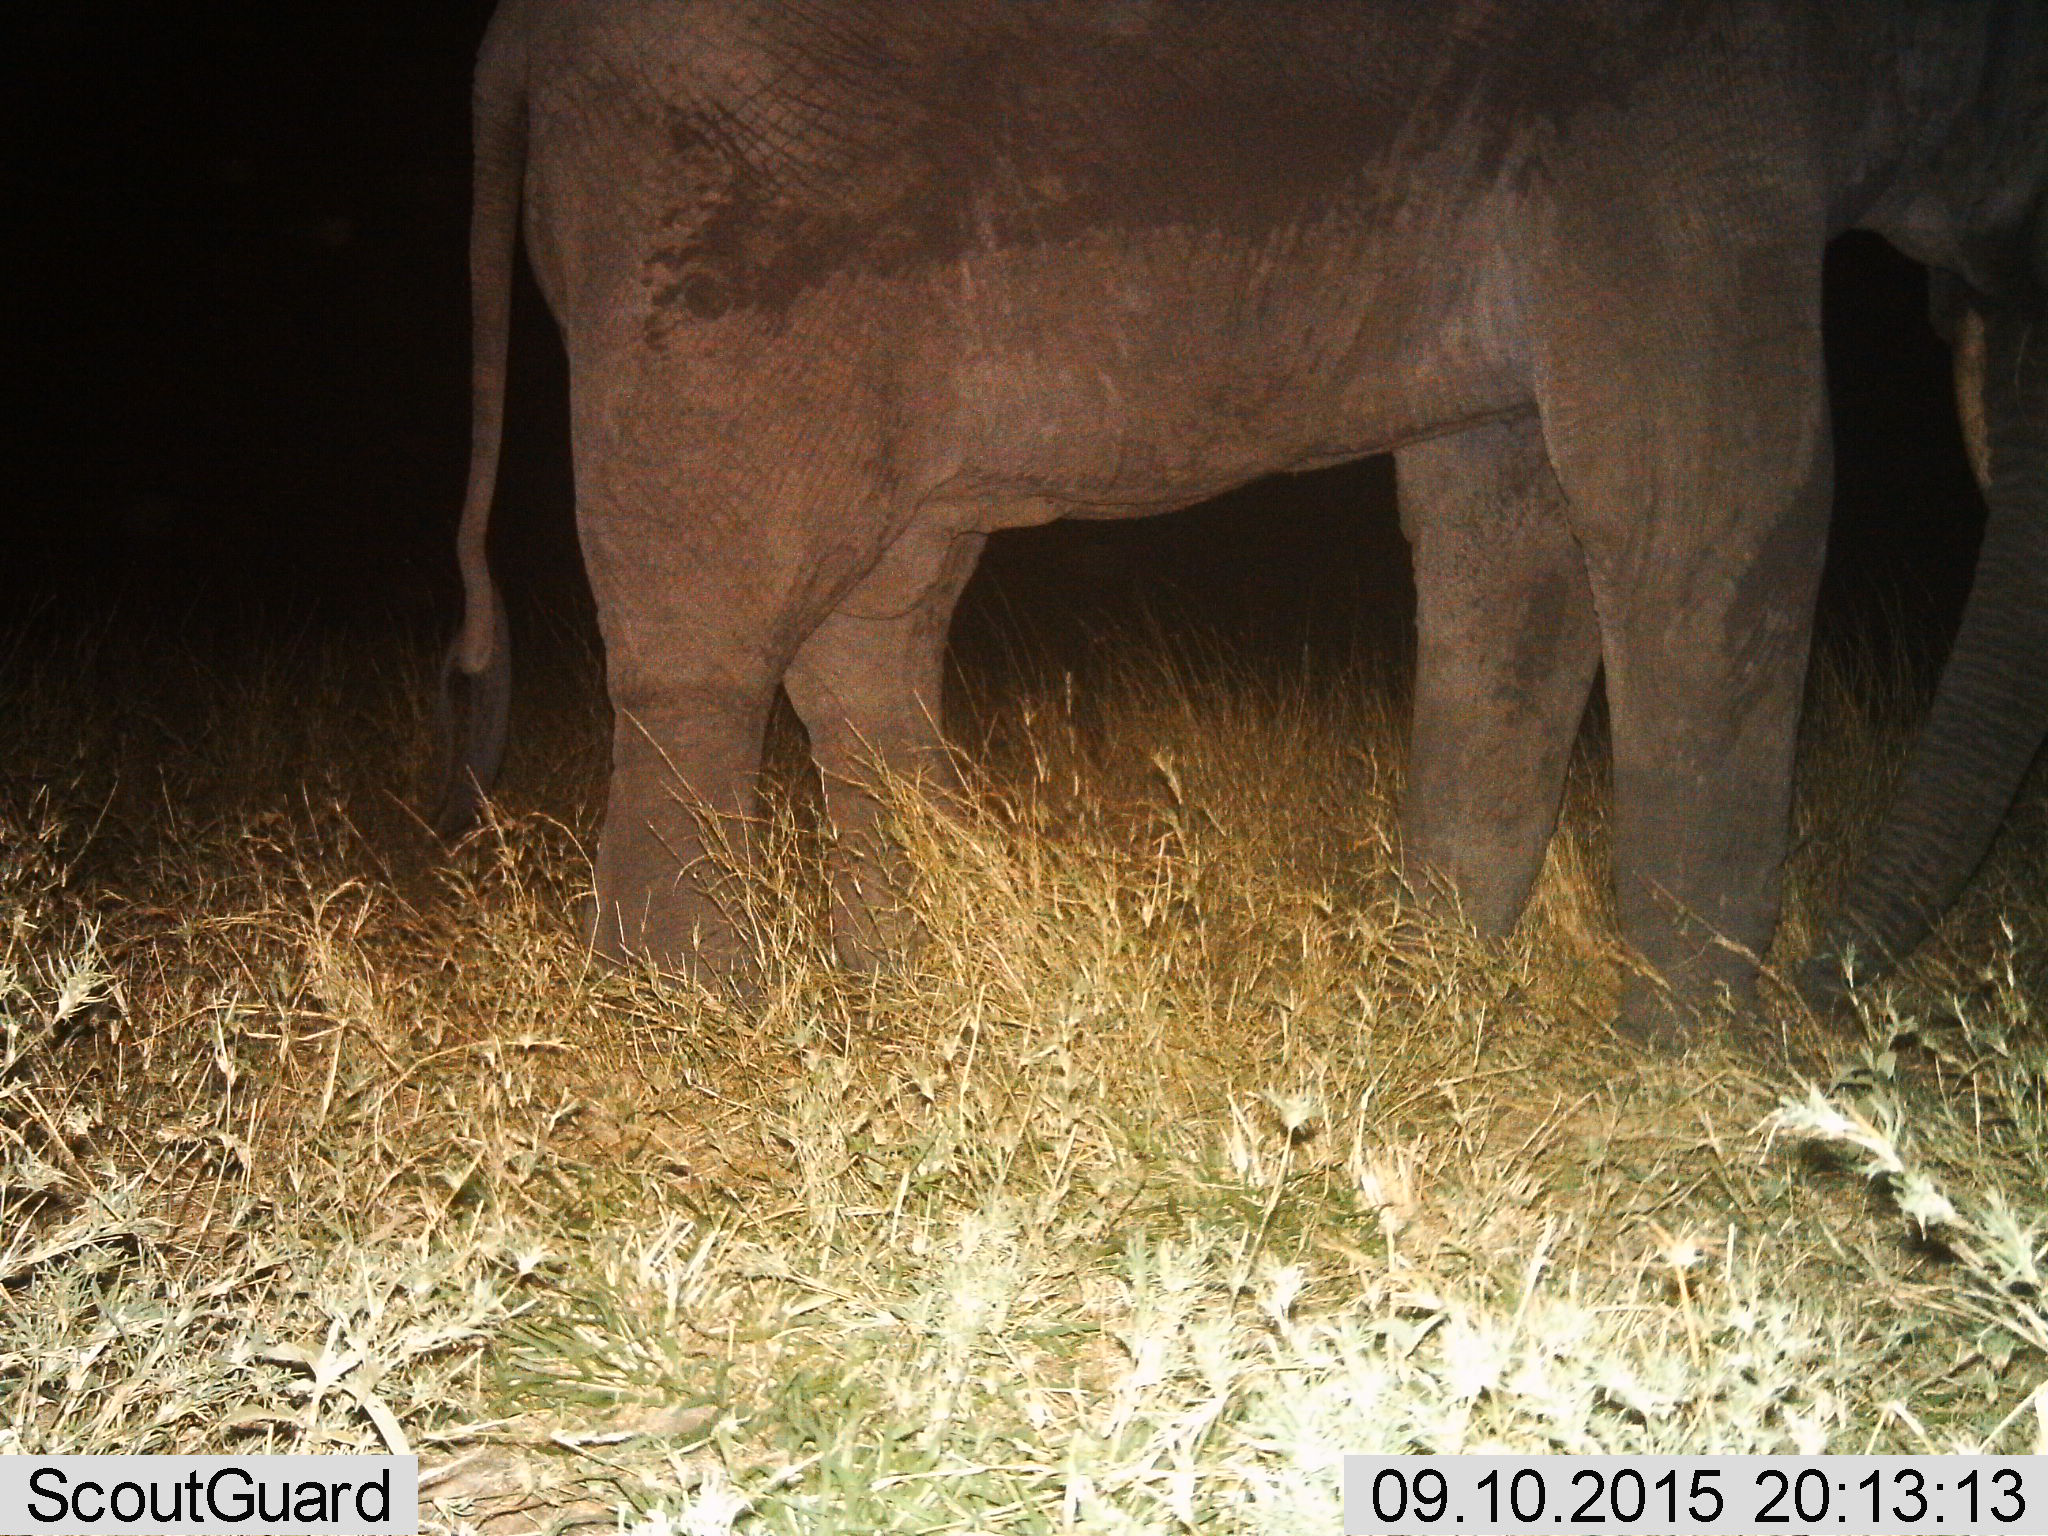

In [19]:
import random

def get_random_jpg_path(root_dir):
    # Define the image file extension for JPG files (case-insensitive)
    jpg_extension = '.jpg'
    jpg_paths = []
    
    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(jpg_extension):
                full_path = os.path.join(dirpath, filename)
                jpg_paths.append(full_path)
    
    # Return a random JPG image if any are found, else return None
    if jpg_paths:
        return random.choice(jpg_paths)
    else:
        return None

# Load a new image from the test data using Pillow
random_image_path = "/lakehouse/default/Files/images/test"
image = Image.open(get_random_jpg_path(random_image_path))
image

In [20]:
# Resize the image to a fixed size
resize_transform = transforms.Resize((224, 224))
image = resize_transform(image)

# Convert the image to a PyTorch tensor
tensor_transform = transforms.ToTensor()
tensor = tensor_transform(image)

# Add a batch dimension to the tensor
tensor = tensor.unsqueeze(0)

# Load the model from MLflow
model = mlflow.pytorch.load_model(model_uri)

# Set the model to evaluation mode
model.eval()

# Pass the tensor through the model to get the output
with torch.no_grad():
    output = model(tensor)

# Get the predicted class
_, predicted = torch.max(output.data, 1)

print(predicted.item())

StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 28, Finished, Available, Finished)

2025/04/01 08:52:42 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


7


StatementMeta(, f6b6c9dd-1493-463a-89e4-b2a751c38c20, 29, Finished, Available, Finished)